***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)    
    * Previous: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)
    * Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](#)

***

Import standard modules:

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [40]:
import matplotlib.image as mpimg
from IPython.display import Image
from astropy.io import fits
import aplpy

***

## 5.4 The Dirty Image and Visibility Weightings <a id='imaging:sec:weights'></a>

Now that we have laid out the concepts of spatial filters, sampling and point spread functions, and gridding for using the fast Fourier transforms, we are ready to connect all this topics into one to show how an image is produced from a radio interferomtric array observation. The so called 'dirty' image (the reason for this term relates to the deconvolution stage which is covered in the next chapter) from an observation is approximately

$$ I^{\textrm{D}}(l,m) \approx \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} S(u,v) \, V_{\textrm{obs}}(u,v) \, e^{-2\pi i(ul+vm)} \,du\,dv $$

where $V_{\textrm{obs}}(u,v)$ is the observated visibilities, this function is a complete measurement of the uv domain, which in reality is never measured because $S(u,v)$ is the sampling function, the main component of which is the uv coverage of the baseline tracks. This is an approximate result as we have used the small angle approximation to reduce the complete 3-d visibility equation to 2-d. The limits to this approximation and how to correct for the 'w-term' is covered in the next section.

The sampling function $S$, as we have seen in the previous section on gridding, contains the uv track sampling and the gridding operator. And, as we will see later in this chapter, the sampling function will be generalized to include various 'weighting' functions. It is often useful to talk of the sampled visibilities

$$ V^{\textrm{S}} = S(u,v) \, V_{\textrm{obs}}(u,v) $$

which is combination of the visibility samples from all baselines onto a single visibility-space plane. Comparing the dirty image equation to that of the 2-d Fourier transform in Section 5.1 we see that the dirty image is simply the Fourier transform of the sampled visibilities.

$$ I^{\textrm{D}} = \mathscr{F}\{V^{\textrm{S}}\} = \mathscr{F}\{ S V_{\textrm{obs}}\}$$

The $(l,m)$ and $(u,v)$ notation has been dropped here for compactness. By Fourier theory the dirty image can be interpreted as a convolution of two functions. 

$$ I^{\textrm{D}} = \mathscr{F}\{ S \} \circ \mathscr{F}\{ V_{\textrm{obs}}\}$$

As we have seen in Section 5.2 the first function $\mathscr{F}\{ S \}$ is the PSF response of the array, which we have seen in Section 5.2 is dependent on the array configuration, sky poisiton, observation time, and frequency coverage. The second function $\mathscr{F}\{ V_{\textrm{obs}}\}$ is the Fourier transform of the fully sampled visibility space. We never has access to $V_{\textrm{obs}}$, but as we will see in the next chapter, we include *a priori* information to make an approximate reconstruction of $V_{\textrm{obs}}$. We can think of $\mathscr{F}\{ V_{\textrm{obs}}\}$ being the ideal image $I^{\textrm{ideal}}$ reconstructed from fulling sampling the visibility plane. Re-writing the equation above the dirty image is the convolution of the array PSF with the ideal image.

$$ I^{\textrm{D}} = \textrm{PSF} \circ I^{\textrm{ideal}}$$

Returning to examples from earlier in the chapter we can construct a dirty image from the original duck image and the KAT-7 PSF response from one of the observations in Section 5.2.

In [41]:
duck = mpimg.imread('figures/Anas_platyrhynchos_male_female_quadrat_512.png')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

gDuck = rgb2gray(duck)
fftDuck = np.fft.fft2(gDuck) #take the Fourier transform of the image to poduce the observed visibilities

In [42]:
hdulist = fits.open('figures/psfs/KAT-7_6h60s_dec-30_10MHz_100chans-psf.fits')
psf = hdulist[0].data #shape [polarization, channel, m, l]
sampFunc = np.fft.fft2(psf[0,0]) #take the Fourier transform of the PSF to generate the gridded sampling function

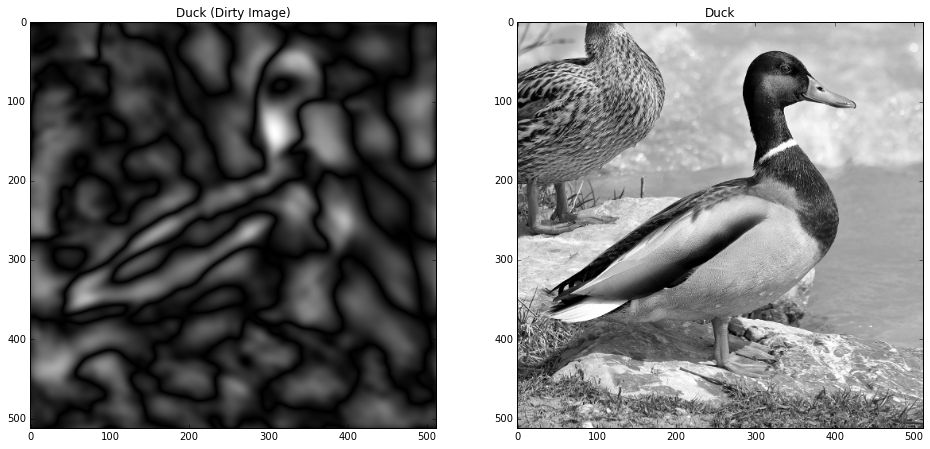

In [70]:
fig, axes = plt.subplots(figsize=(16,8))

ax1 = plt.subplot(1,2,1)
fftDirtyImg = sampFunc * fftDuck #multiplication in Fourier space is equivalent to convolution in image space
dirtyImg = np.abs(np.fft.fftshift(np.fft.ifft2(fftDirtyImg))) #create the dirty image
plt.title('Duck (Dirty Image)')
imgPlot0 = plt.imshow(dirtyImg)
imgPlot0.set_cmap('gray')

ax2 = plt.subplot(1,2,2)
plt.title('Duck')
imgPlot1 = plt.imshow(gDuck)
imgPlot1.set_cmap('gray')

*Figure: dirty image of a duck (left) created by sampling the original duck image (right) with a KAT-7 observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

It is hard to make out the duck in the resulting dirty image. The head and long wing can be picked out, but that is likely due to the fact that we know what the original image looked like. Had we not known what the original image was we would have a difficult time deciding what we are seeing is the real image and what is due to the PSF sidelobes. This is the main issue in interferometric imaging, and perpetuated the development of deconvolution algorithms.

Plotting the Fourier transform of the PSF should result in a similar image of the uv coverage plot seen in Section 5.2. Indeed it does, but notice that the color bar suggests a range of pixel values. This comes back to the overlapping uv tracks we saw in the uv coverage plots and the type of weighting scheme which was used to produce the PSF. We have been hiding a few details up until this point to simplify the presentation of sampling functions and how they affect resulting images. But, now we will generalize sampling function to introduce weighting functions.

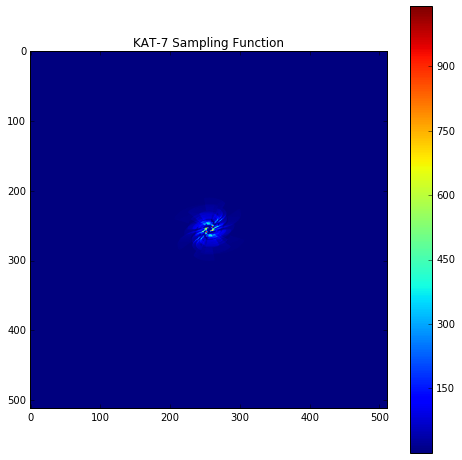

In [44]:
fig = plt.figure(figsize=(8,8))
plt.title('KAT-7 Sampling Function')
imgPlot = plt.imshow(np.abs(np.fft.fftshift(sampFunc)))
plt.colorbar()

*Figure: KAT-7 sampling function for an observation using 100 frequency channels, over a 6 hour observation at declination -30 degrees.*

### 5.1 Weighting Functions, a generalization of sampling functions

The sampling function, as seen in the Section 5.2 KAT-7 examples, are made up of the various baseline tracks which leads to holes and overlapping sampling. So far we have discussed sampling functions as if they are binary functions, a visibility domain pixel is given a value of 1 if a baseline track measured that location otherwise the pixel was given a value of 0. The allocation of 0 to each pixel which was not measured should make sense, as there is no information, and thuse that pixel can potentially have any value. But, for the measured pixels the sampling function value does not necessarily need to be 1. For example, say an observation results in 1000 uv positions being measured, and 100 of these positions were measured 10 times while the other 900 positions were only measured once. The 100 positions measured 10 times, will have a $\sqrt{10}$ improvement in sensitivity compared to the other 900 positions, so perhaps those 100 spatial frequency modes should be given more weight in the resulting image because we are more sure about the accuracy of the measurement. Or, perhaps an array is made up of many different types of telescopes which leads to some baselines having a higher sensitivity to other baselines, such as in VLBI. Or, perhaps the science case is only interested in certain spatial frequencies, such as seperating point sources from large-scale gas structure. These are all examples of times when we would like to adjust our sampling function, which leads to a number of different options we need to understand when creating an image. In fact, there is no standard set of options to create an image from visibilities, a weighting function must always be decided upon before hand. The most common weighting function we must decide on when imaging is the density weighting function, but we will also discuss the beam taper and reliability weighting.

As a simplification we have been discussing the PSF as being a Fourier pair of the visibility sampling function, but in fact we need to generalize to say that the PSF is a Fourier pair of a weighting function $W$, where $W$ includes the sampling function.

$$ \textrm{PSF}(l,m) \rightleftharpoons W(u,v)$$

Expanding $W$ we see that it is made up over a number of functions. For this section we will use the notation based on Lecture 7 of <cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II</cite> [CITE](http://adsabs.harvard.edu/abs/1999sira.conf.....T). For compactness the $(u,v)$ terms have been dropped.

$$ W = R \cdot T \cdot D \cdot S $$

$W$ is a product of the the sampling function $S$ which we have all ready discussed, a density weight function $D$, an optional taper weight function $T$, and a baseline-dependent reliability weight function $R$.

As a simple example let us look at some 1-d weight functions and the resulting PSFs. For this example lets say we sample the inner centre of a 1-d function. This results in a square or boxcar sampling, as seen in blue in the left-hand figure below. But, say we think some samples are 'better' than others. For example, our detector has a linear response based on the distance from the zero point. Then, we would like to weigh the samples accordingly, giving more weight to samples near the centre and less to the samples on the far edges. This results in a triangle weight function, as seen in green in the left-hand figure below. Or, perhaps a Gaussian weighting function, red in the left-hand figure below, is more appropriate. There are many types of potential weighting functions which all cover the same extent of the sample space. But, these weighting functions result in different PSF responses as seen in the right-hand figure. Using a boxcar weighting function (blue) results in the highest PSF primary lobe, but the sidelobes are significantly higher compared to other weighting functions. This relates to the idea that a smooth function in one domain is alos a smooth function in the Fourier domain, and a boxcar function is not a smooth function. A Gaussian function is a smooth function, but the sampling extent (or window in signal processing terms) is finite, this means that there is a cut off point. The PSF response of a truncated Gaussian (green) has a wider primary lobe but lower sidelobes compared to the boxcar function. As does the triangle function which can as a simple approximation to the Gaussian.

(0, 512)

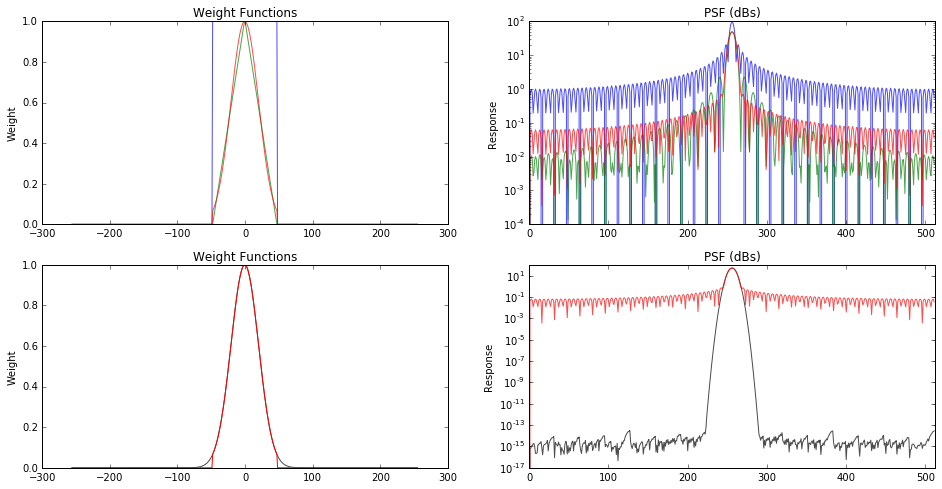

In [59]:
from scipy import signal

whw = 48 #window half width

#Square/Boxcar weight function
squareWeights = np.zeros(512, dtype='float')
squareWeights[256 - whw:256 + whw] = 1.

#Triangle weight function
triWeights = np.zeros(512, dtype='float')
triWeights[256 - whw : 256] = np.linspace(0., 1., num=whw)
triWeights[256 : 256 + whw] = np.linspace(1., 0., num=whw)

#Gaussian weight function
gaussWeights = signal.gaussian(512, std=whw / (2. * np.sqrt(2. * np.log(2.))))
truncGaussWeights = gaussWeights * squareWeights #truncate to window width

xVals = np.arange(-256,256)

fig, axes = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(2,2,1)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, squareWeights, 'b-', alpha=0.7)
plt.plot(xVals, triWeights, 'g-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=0.7)
#plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)

ax1 = plt.subplot(2,2,2)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(squareWeights))), 'b-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(triWeights))), 'g-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
#plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

ax1 = plt.subplot(2,2,3)
plt.title('Weight Functions')
plt.ylabel('Weight')
plt.plot(xVals, gaussWeights, 'k-', alpha=0.7)
plt.plot(xVals, truncGaussWeights, 'r-', alpha=1.0)

ax1 = plt.subplot(2,2,4)
plt.title('PSF (dBs)')
plt.ylabel('Response')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(gaussWeights))), 'k-', alpha=0.7)
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(truncGaussWeights))), 'r-', alpha=0.7)
ax1.set_yscale('log')
plt.xlim(0, 512)

*Top: examples of 1-d weight functions: square (blue), triangle (green), truncated Gaussian (red) and the resulting PSF responses.*

*Bottom: Gaussian (black) and truncated Gaussian (red) weighting function and the resulting PSF responses. The low level 'noise' in the Gaussian response is due to computational accuracy limits.*

The figure above shows just three possible weighting functions and the resulting PSF responses. There is no 'correct' function, each has advantages and disadvantages. A boxcar function maximizes the PSF primary lobe response but at the expense of high sidelobes. A triangle function minimizes sidelobes but at the expense of some loss in signal, and a loss of resolution (as does the Gaussian). This loss in resolution (that is a wider primary lobe) is because the weight function gives more value to the samples near the centre point, i.e. the lower spatial modes.

As we will see, we can decide on a weighting function when synthesising an image to emphasize for resolution or sensitivity or a combination of the two in the density weighting funciton.

### 5.2 Density Functions

When discussion of weighting functions (or schemes) comes up in conversations, presentations, or papers it is almost always referring to *density weighting functions*. A density weighting function is used to set the weights of individual uv positions based on the number of times that position is sampled in an observation. One will often see terms such as 'uniform' and 'natural' weighting which are types of density weighting functions.

Going back to the KAT-7 sampling function plot shown earlier, we see that the pixels range in values. That is, during the observation those pixels in the visibility domain were sampled multiple times due to a combination of the frequency bandwidth coverage and the uv track positions. In this case, when we formed the PSF response we decided to give each sample a equal weighting, this resulted in the pixels have a range of weights. This is similar to the Gaussian weighting function in the 1-d example above. This weighting scheme is called *natural weighting*, it has the advantage of maximizing sensitivity but at the cost of resolution.

A complimentary weight scheme is *uniform weighting* which weights each sample positon equally, not matter how many times that position was sampled. This is akin to the boxcar weighting function in the 1-d example above, and results in a higher resolution image at the cost of higher PSF sidelobes.

* mathematical description of uniform and natural

When to use a specific weighting scheme depends on the what the goal of the observation is. If you are trying to maximize resolution and are willing to lose some sensitivty then you use uniform weighting. And, if you are observing a weak source and are willing to lose some resolution then you use natural weighting.

* figure: natural, uniform weighted psfs and maps

* generalize: briggs robust

* figure: robust weighting through a range of values

* additional weightings notes

Briggs' thesis <cite data-cite='briggs1995high'>High Fidelity Deconvolution of Moderately Resolved Sources</cite> [CITE](http://www.aoc.nrao.edu/dissertations/dbriggs/)

### 5.3 Taper Functions

Tapers for beam scaling/spatial filter:

* spatial gaussian filters, relate to sharpen and blur filters
* use case: smoothness at the price of resolution, filtering out lower modes to get to point sources

* figure: field with different Gaussian tapers

* relation to weighting schemes

### 5.4 Measurment Reliability

Reliability:

* baseline dependent reliability, inherent in the measurement
* VLBI/ALMA/mixed telescope arrays

### 5.5 Limits of the Dirty Image

Conclusion to section:

* limits of dirty image, lead into deconvolution
* figure: dense field with high sidelobes

* lead into w-term issues
* figure: w-projection effect

***

Next: [5.5 The Break Down of the Small Angle Approximation and the W-Term](#)